## Overview

This is a project for automating trading. I am using Twelve Data API to access stock data. My algorithms will probably rely on technical analysis rather than fundamental analysis: data about the stocks movements rather than company releases, as I can automate this stuff easily.

## TwelveData API Tools

[Here is the documentation page for the API.](https://twelvedata.com/docs)

[Here is a tutorial for a library.](https://twelvedata.com/blog/get-high-quality-financial-data-directly-into-python)

[Here is the library's GitHub repository.](https://github.com/twelvedata/twelvedata-python)


I'm allowed up to 800 calls per day.


## Setup

The first steps in this project are setting up this venv with my desired libraries. I am installing: 

>`pip install twelvedata[matplotlib, plotly]`


## First Steps

I will begin by practicing fetching data from the API and displaying it. This will help me using tools to graphically represent data.

In [4]:
from twelvedata import TDClient
import json
import datetime


td = TDClient(apikey="a2edbe9124ce46adba66a0b007253f80")

# Construct the necessary time series
ts = td.time_series(
    symbol="AAPL",
    interval="1min",
    timezone="America/New_York",
    outputsize=1
).as_json()

# with open("results.txt", "w") as f: 
#     f.write(ts.to_string())

with open("results.txt", "w") as f: 
    f.write(json.dumps(ts, indent=4))


## First Algorithm

This algorithm will buy some AAPL stock if the price is below a certain number. 

First, I will create the sandbox that keeps track of my possesions. I will have the API connection to the external world as a given. Second, I will work on using the API to interact with the world to get the data I want.

As I go forward, I will iterate over the first step to improve the algorithm. 

Stipulations:
* 2023-04-04 8:11 AM: The API returns a range of prices of an asset over a time interval. I will take the current price to be the open.

In [17]:
"""
This is the basic structure for the trading algorithm. This creates the environment that manages possessions and transactions. That occurs client-side. 


The API is contained in the function that fetches data. Everything else occus on the machine.
"""
from twelvedata import TDClient
import json

td = TDClient(apikey="a2edbe9124ce46adba66a0b007253f80")

# Bridge to the stock market.
def fetch_stock_data(stock_ticker, interval, size):
    """
    Gets the necessary data from the API as a PANDAS dataframe.

    Argument:
        stock_ticker (string): ticker 
        interval (string): time frame (1min, 5min, 15min, 30min, 45min, 1h, 2h, 4h, 8h, 1day, 1week, 1month)
        size (int): the number of data points to retrieve

    Return (dict):
        price per share at time of call
    """
    # Construct the time series
    ts = td.time_series(
        symbol=stock_ticker,
        interval=interval,
        timezone="America/New_York",
        outputsize=size
    ).as_pandas()
    return ts



### This will define the decision algorithms

In [18]:
# Buy/Sell if stock is increasing / decreasing in value 
def decide_buy(stock_data):
    """
    Decide whether to buy a stock
    Buys if the 50-day moving average is greater than the 100-day moving average

    Argument: 
        stock_data (pandas df)

    Return:
        choice (boolean)
    """
    long = stock_data['close'].copy().ewm(span=100).mean()
    short = stock_data['close'].copy().ewm(span=50).mean()
    return short[0] > long[0] and abs(short - long) < 1

def decide_sell(stock_data):
    """
    Decide whether to sell a stock

    Argument: 
        stock_data (pandas df)

    Return:
        choice (boolean)
    """
    long = stock_data['close'].copy().ewm(span=100).mean()
    short = stock_data['close'].copy().ewm(span=50).mean()
    return short[0] < long[0] and abs(short - long) < 1



In [73]:
import pandas as pd

stock_data = fetch_stock_data("AAPL", "1day", 100)

print(len(stock_data))

long = stock_data['close'].copy().rolling(100).mean()
short = stock_data['close'].copy().rolling(50).mean()

long = long[long.notnull()]
short = short[short.notnull()]

print(long.iloc[0])
print("--")
print(short.iloc[0])

100
datetime
2023-04-26    181.5906
Name: close, dtype: float64
--
datetime
2023-07-10    184.465701
2023-07-07    184.719701
2023-07-06    185.055701
2023-07-05    185.367501
2023-07-03    185.732501
2023-06-30    186.085901
2023-06-29    186.290501
2023-06-28    186.511901
2023-06-27    186.721901
2023-06-26    186.769101
2023-06-23    186.708701
2023-06-22    186.659501
2023-06-21    186.581301
2023-06-20    186.528501
2023-06-16    186.544501
2023-06-15    186.660901
2023-06-14    186.767701
2023-06-13    186.906301
2023-06-12    186.959700
2023-06-09    187.034301
2023-06-08    187.128901
2023-06-07    187.195501
2023-06-06    187.299701
2023-06-05    187.359901
2023-06-02    187.429901
2023-06-01    187.442501
2023-05-31    187.431701
2023-05-30    187.418301
2023-05-26    187.363101
2023-05-25    187.226901
2023-05-24    187.086701
2023-05-23    186.878100
2023-05-22    186.538700
2023-05-19    186.190300
2023-05-18    185.779200
2023-05-17    185.304000
2023-05-16    184.828801

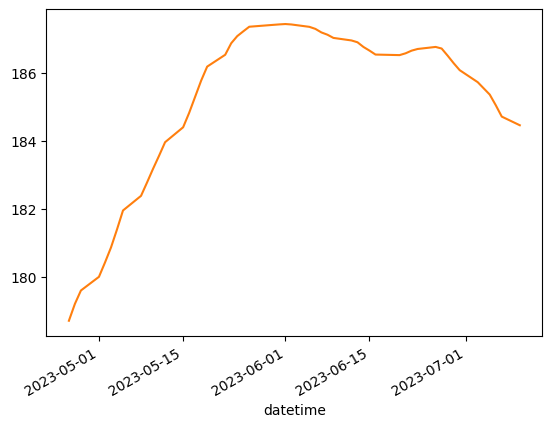

In [75]:
import matplotlib.pyplot as plt

long.plot()
short.plot()
plt.show()